<a href="https://colab.research.google.com/github/tanyasheru23/PyTorch/blob/main/03_pytorch_MultiClassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Creating a toy multi-class dataset


In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

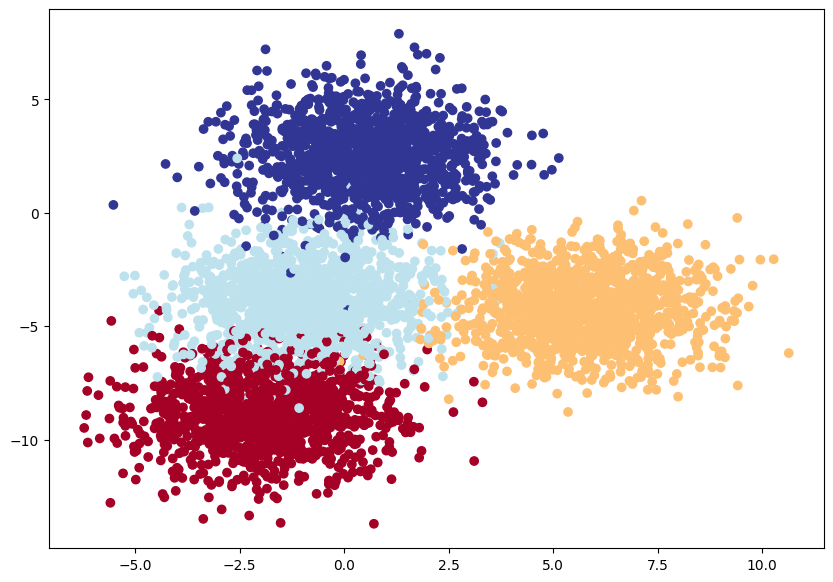

In [75]:
# Set hyperparameters for data creation

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


# 1. Create multi-class data
x_blob, y_blob = make_blobs(n_samples = 5000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = 40)

# 2. Turn data into Tensors (since scikit learn uses numpy)

X_blob, y_blob = torch.from_numpy(x_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.float)

# 3. Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size = 0.3, random_state = 42)


# 4. Plot data
plt.figure(figsize = (10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c = y_blob, cmap = plt.cm.RdYlBu)
plt.show()

In [76]:
df = pd.DataFrame({'X1': X_blob[:,0],
                   'X2': X_blob[:,1],
                   'y' : y_blob})

In [77]:
torch.unique(y_blob)

tensor([0., 1., 2., 3.])

## Building a Multi-class classification model

In [78]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [79]:
import torch.nn as nn

In [80]:
class BlobModelMultiClass(nn.Module):
  def __init__(self, in_feat, out_feat, h1_units = 8, h2_units = 5):
    super().__init__()
    # self.layer1 = nn.Linear(in_features = in_feat, out_features = h1_units)
    # self.layer2 = nn.Linear(in_features = h1_units, out_features = h2_units)
    # self.layer3 = nn.Linear(in_features = h2_units, out_features = out_feat)

    # self.relu = nn.ReLu()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features = in_feat, out_features = h1_units),
        nn.ReLU(),
        nn.Linear(in_features = h1_units, out_features = h2_units),
        nn.ReLU(),
        nn.Linear(in_features = h2_units, out_features = out_feat)
    )

  def forward(self, X):
    # return self.layer3(self.relu(self.layer2(self.relu(self.layer1))))
    return self.layer_stack(X)

model_ = BlobModelMultiClass(in_feat = 2, out_feat = 4).to(device)

In [81]:
model_

BlobModelMultiClass(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=4, bias=True)
  )
)

In [82]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_.parameters(),
                             lr = 0.1)

### Getting pred probs for multi-class model in PyTorch

> Logits(raw) → Pred Probs → Pred  Labels


In [83]:
y_test[:10]

tensor([0., 2., 0., 3., 2., 2., 2., 3., 0., 3.])

In [84]:
model_.eval()
with torch.inference_mode():
  y_logits = model_(X_test)
y_logits

tensor([[ 0.2710, -0.1769, -0.3890,  0.4970],
        [ 0.1512, -0.0417, -0.1632,  0.3710],
        [ 0.3315, -0.3194, -0.4724,  0.5770],
        ...,
        [ 0.2955, -0.2665, -0.4167,  0.5426],
        [ 1.2858, -0.7209, -0.6722,  0.0737],
        [ 0.2448, -0.1245, -0.3360,  0.4528]])

In [85]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs

tensor([[0.2933, 0.1874, 0.1516, 0.3677],
        [0.2631, 0.2170, 0.1921, 0.3278],
        [0.3079, 0.1606, 0.1378, 0.3936],
        ...,
        [0.2993, 0.1706, 0.1468, 0.3832],
        [0.6357, 0.0855, 0.0897, 0.1892],
        [0.2872, 0.1985, 0.1607, 0.3536]])

In [86]:
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:10]

tensor([3, 3, 3, 0, 3, 3, 3, 0, 3, 0])

In [87]:
loss = loss_fn(y_logits, y_test.type(torch.LongTensor))

## Evaluation Metrics for Classification

NEED TO IMPORT TORCHMETRICS (after installing)

* Accuracy - how many does our model got right, out of 100 samples (best useful for balanced classes, not for imbalanced) `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()`
* Precision - Number of actually postive out of all predicted postives `torchmetrics.Precision()`

> Higher precision leads to less false positives

* Recall - Number of correctly predicted positive out of actual positives `torchmetrics.Recall()`

> Higher recall leads to less false negatives
* F1- Score - Combination of Precision and Recall `torchmetrics.F1Score()`
* Confusion Matrix - `torchmetrics.ConfusionMatrix()`
* Classification Report - `sklearn.metrics.classification_report()`

*If needed to implement own metric, subclass the `Metric` class.*

In [88]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## Traning loop and testing

In [89]:
torch.manual_seed(42)
epochs = 200

for epoch in range(epochs):
  model_.train()
  y_logits = model_.forward(X_train)
  y_pred_probs = torch.softmax(y_logits, dim = 1)
  y_pred = torch.argmax(y_pred_probs, dim = 1)

  loss = loss_fn(y_logits, y_train.type(torch.LongTensor))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  train_acc = accuracy_fn(y_train, y_pred)

  ### Testing
  model_.eval()
  with torch.inference_mode():
    test_logits = model_(X_test)
    test_preds = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)

    test_loss = loss_fn(test_logits, y_test.type(torch.LongTensor))
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Train Acc: {train_acc} | Test loss: {test_loss} | Test Acc: {test_acc}")

Epoch: 0 | Train loss: 1.6878669261932373 | Train Acc: 2.4857142857142858 | Test loss: 1.3387888669967651 | Test Acc: 45.53333333333333
Epoch: 20 | Train loss: 0.5096214413642883 | Train Acc: 75.34285714285714 | Test loss: 0.45881789922714233 | Test Acc: 80.80000000000001
Epoch: 40 | Train loss: 0.2949203848838806 | Train Acc: 89.17142857142856 | Test loss: 0.2101559042930603 | Test Acc: 94.13333333333334
Epoch: 60 | Train loss: 0.13408979773521423 | Train Acc: 95.54285714285714 | Test loss: 0.11601215600967407 | Test Acc: 96.6
Epoch: 80 | Train loss: 0.12179432809352875 | Train Acc: 95.57142857142857 | Test loss: 0.10346444696187973 | Test Acc: 96.46666666666667
Epoch: 100 | Train loss: 0.11583079397678375 | Train Acc: 95.74285714285715 | Test loss: 0.10011981427669525 | Test Acc: 96.39999999999999
Epoch: 120 | Train loss: 0.11374868452548981 | Train Acc: 95.8 | Test loss: 0.09836804121732712 | Test Acc: 96.46666666666667
Epoch: 140 | Train loss: 0.11279100924730301 | Train Acc: 95.82

In [104]:
def plot_decision_boundary(model, X, y):
  # X, y = X.to_numpy(), y.to_numpy()
  x1_min, x1_max = X[:,0].min(), X[:,0].max()
  x2_min, x2_max = X[:,1].min(), X[:,1].max()
  x1x1, x2x2 = np.meshgrid(np.linspace(x1_min, x1_max, 201), np.linspace(x2_min, x2_max, 201))

  # features
  feat_x1 = np.ravel(x1x1)
  feat_x2 = np.ravel(x2x2)
  feat_ = torch.from_numpy(np.column_stack((feat_x1, feat_x2))).float()

  # make predictions
  model.eval()
  with torch.inference_mode():
    preds = model(feat_)
    preds = torch.argmax(torch.softmax(preds, dim = 1), dim = 1)

  preds = preds.reshape(x1x1.shape)
  plt.contourf(x1x1, x2x2, preds, cmap = plt.cm.RdYlBu, alpha = 0.7)
  plt.scatter(X[:,0], X[:,1], c = y, s = 40, cmap = plt.cm.RdYlBu)
  plt.xlim(x1x1.min(), x1x1.max())
  plt.ylim(x2x2.min(), x2x2.max())

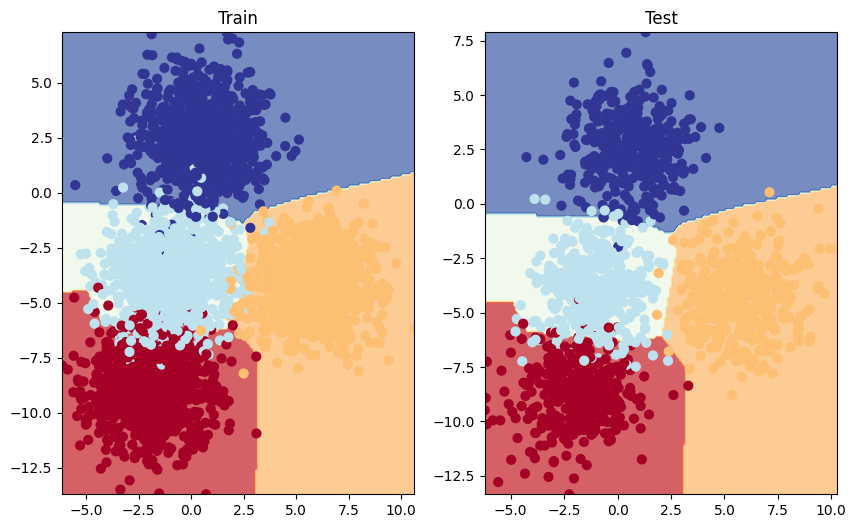

In [105]:
plt.figure(figsize = (10, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_, X_test, y_test)

In [ ]:
!pip install torchmetrics

In [91]:
from torchmetrics import Accuracy, Precision, Recall

In [92]:
torch_acc = Accuracy(task="multiclass", num_classes=4)
torch_acc(test_preds, y_test)

tensor(0.9607)

In [93]:
from torchmetrics import ConfusionMatrix
confmat = ConfusionMatrix(task="multiclass", num_classes=4)
confmat(test_preds, y_test)

tensor([[350,   1,  10,   0],
        [  1, 380,   2,   1],
        [ 30,   1, 335,   7],
        [  0,   0,   6, 376]])